In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import os as os
import time as time
import seaborn as sns
import glob as glob

from scipy import stats
from scikit_posthocs import posthoc_tukey
from statsmodels.stats.multitest import fdrcorrection as fdr
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from itertools import combinations
from scipy.spatial import distance
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import squareform
from sklearn import manifold
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
from statannotations.Annotator import Annotator
import itertools as itls
%matplotlib inline

In [2]:
sampinfo=pd.read_csv('Count.csv',index_col=0)
deseqsampinfo=pd.read_csv('Sample_Info.csv',index_col=0)
nondeseq=[x for x in sampinfo.index.tolist() if x not in deseqsampinfo.index.tolist()]
sampinfo.loc[nondeseq,"Remove"]='Yes'
meta = sampinfo['G4'].tolist()

In [3]:
### this block just separates out the different sample types for further inspections and then lists the comparable samples##
gpcol='G4'
sampcols=sampinfo.columns.tolist()
synlist=[x for x in sampcols if 'SynCom' in x]
sumlist=[x for x in sampcols if 'Sum' in x]
sumlist=sumlist[1:] #delete column "Sum"
fraclist=[x for x in sampcols if 'Frac' in x]
sampgrps=sampinfo[[gpcol,'Remove']]

grouplist=np.sort(list(set(sampinfo[gpcol].tolist())))
for ddx,gpl in enumerate(grouplist):
    print(ddx,gpl)

0 Attached sand_EcoFAB_Brachypodium_No_N_21_21
1 Attached sand_EcoFAB_Brachypodium_No_N_24_21
2 Attached sand_EcoFAB_Brachypodium_No_N_29_21
3 Attached sand_EcoFAB_Brachypodium_Yes_0_14_14
4 Attached sand_EcoFAB_Brachypodium_Yes_0_21_21
5 Attached sand_EcoFAB_Brachypodium_Yes_3_14_11
6 Attached sand_EcoFAB_Brachypodium_Yes_3_24_21
7 Attached sand_EcoFAB_Brachypodium_Yes_8S_29_21
8 Attached sand_EcoFAB_Brachypodium_Yes_8_14_6
9 Attached sand_EcoFAB_Brachypodium_Yes_8_29_21
10 Root_EcoFAB_Brachypodium_No_N_21_21
11 Root_EcoFAB_Brachypodium_No_N_24_21
12 Root_EcoFAB_Brachypodium_No_N_29_21
13 Root_EcoFAB_Brachypodium_Yes_0_14_14
14 Root_EcoFAB_Brachypodium_Yes_0_21_21
15 Root_EcoFAB_Brachypodium_Yes_3_14_11
16 Root_EcoFAB_Brachypodium_Yes_3_24_21
17 Root_EcoFAB_Brachypodium_Yes_8S_29_21
18 Root_EcoFAB_Brachypodium_Yes_8_14_6
19 Root_EcoFAB_Brachypodium_Yes_8_29_21
20 SynCom mix_liquid_None_Yes_0_0_0
21 nan
22 unattached sand_EcoFAB_Brachypodium_No_N_21_21
23 unattached sand_EcoFAB_Brachyp

In [4]:
### Select a list of samples using the #s - they don't have to be in a row, separate with a comma ###
selset = [20, 32, 36, 35, 33, 34]
compgrps=grouplist[selset]
selgrps=sampgrps[(sampgrps[gpcol].isin(compgrps))]
selgrps.sort_values(gpcol)

namecols=[]
remlist=selgrps['Remove'].tolist()
for rml in remlist:
    if rml=='Yes':
        namecols.append('r')
    else:
        namecols.append('k')

In [5]:
# Select sumplot, then calculate samples by group (G4)
sumplot=sampinfo.loc[selgrps.index.tolist(),sumlist]
avgsumplot=pd.concat([sumplot, selgrps], axis=1) #concatenating with the column name as the name of each dataframe
selavgs = avgsumplot.groupby([gpcol, 'Remove'], dropna=False)[sumlist].mean().reset_index() #calculate the mean of each bacteria within each group
selavgs[['Remove']] = selavgs[['Remove']].fillna('')
selavgs['combined_name'] =  selavgs[gpcol] + selavgs['Remove']

### Re-listing samples the samples for convenience
selgrouplist=np.sort(list(set(selavgs[gpcol].tolist())))
for ddx,gpl in enumerate(selgrouplist):
    print(ddx,gpl)

0 SynCom mix_liquid_None_Yes_0_0_0
1 unattached sand_EcoFAB_None_Yes_0_0_0
2 unattached sand_EcoFAB_None_Yes_0_14_14
3 unattached sand_EcoFAB_None_Yes_0_21_21
4 unattached sand_EcoFAB_None_Yes_3_14_11
5 unattached sand_EcoFAB_None_Yes_8_14_6


In [6]:
# Select synplot, then calculate samples by group (G4)
synplot=sampinfo.loc[selgrps.index.tolist(),synlist]
avgsynplot=pd.concat([synplot, selgrps], axis=1)
selsynavgs = avgsynplot.groupby([gpcol, 'Remove'], dropna=False)[synlist].mean().reset_index()
selsynavgs[['Remove']] = selsynavgs[['Remove']].fillna('')
selsynavgs['combined_name'] =  selsynavgs[gpcol] + selsynavgs['Remove']

### Re-listing samples the samples for convenience
selsynavggrouplist=np.sort(list(set(selsynavgs[gpcol].tolist())))
for ddx,gpl in enumerate(selsynavggrouplist):
    print(ddx,gpl)
levels=[0, 1, 5, 4, 2, 3]
selsynavgs = selsynavgs.reindex(levels) 

0 SynCom mix_liquid_None_Yes_0_0_0
1 unattached sand_EcoFAB_None_Yes_0_0_0
2 unattached sand_EcoFAB_None_Yes_0_14_14
3 unattached sand_EcoFAB_None_Yes_0_21_21
4 unattached sand_EcoFAB_None_Yes_3_14_11
5 unattached sand_EcoFAB_None_Yes_8_14_6


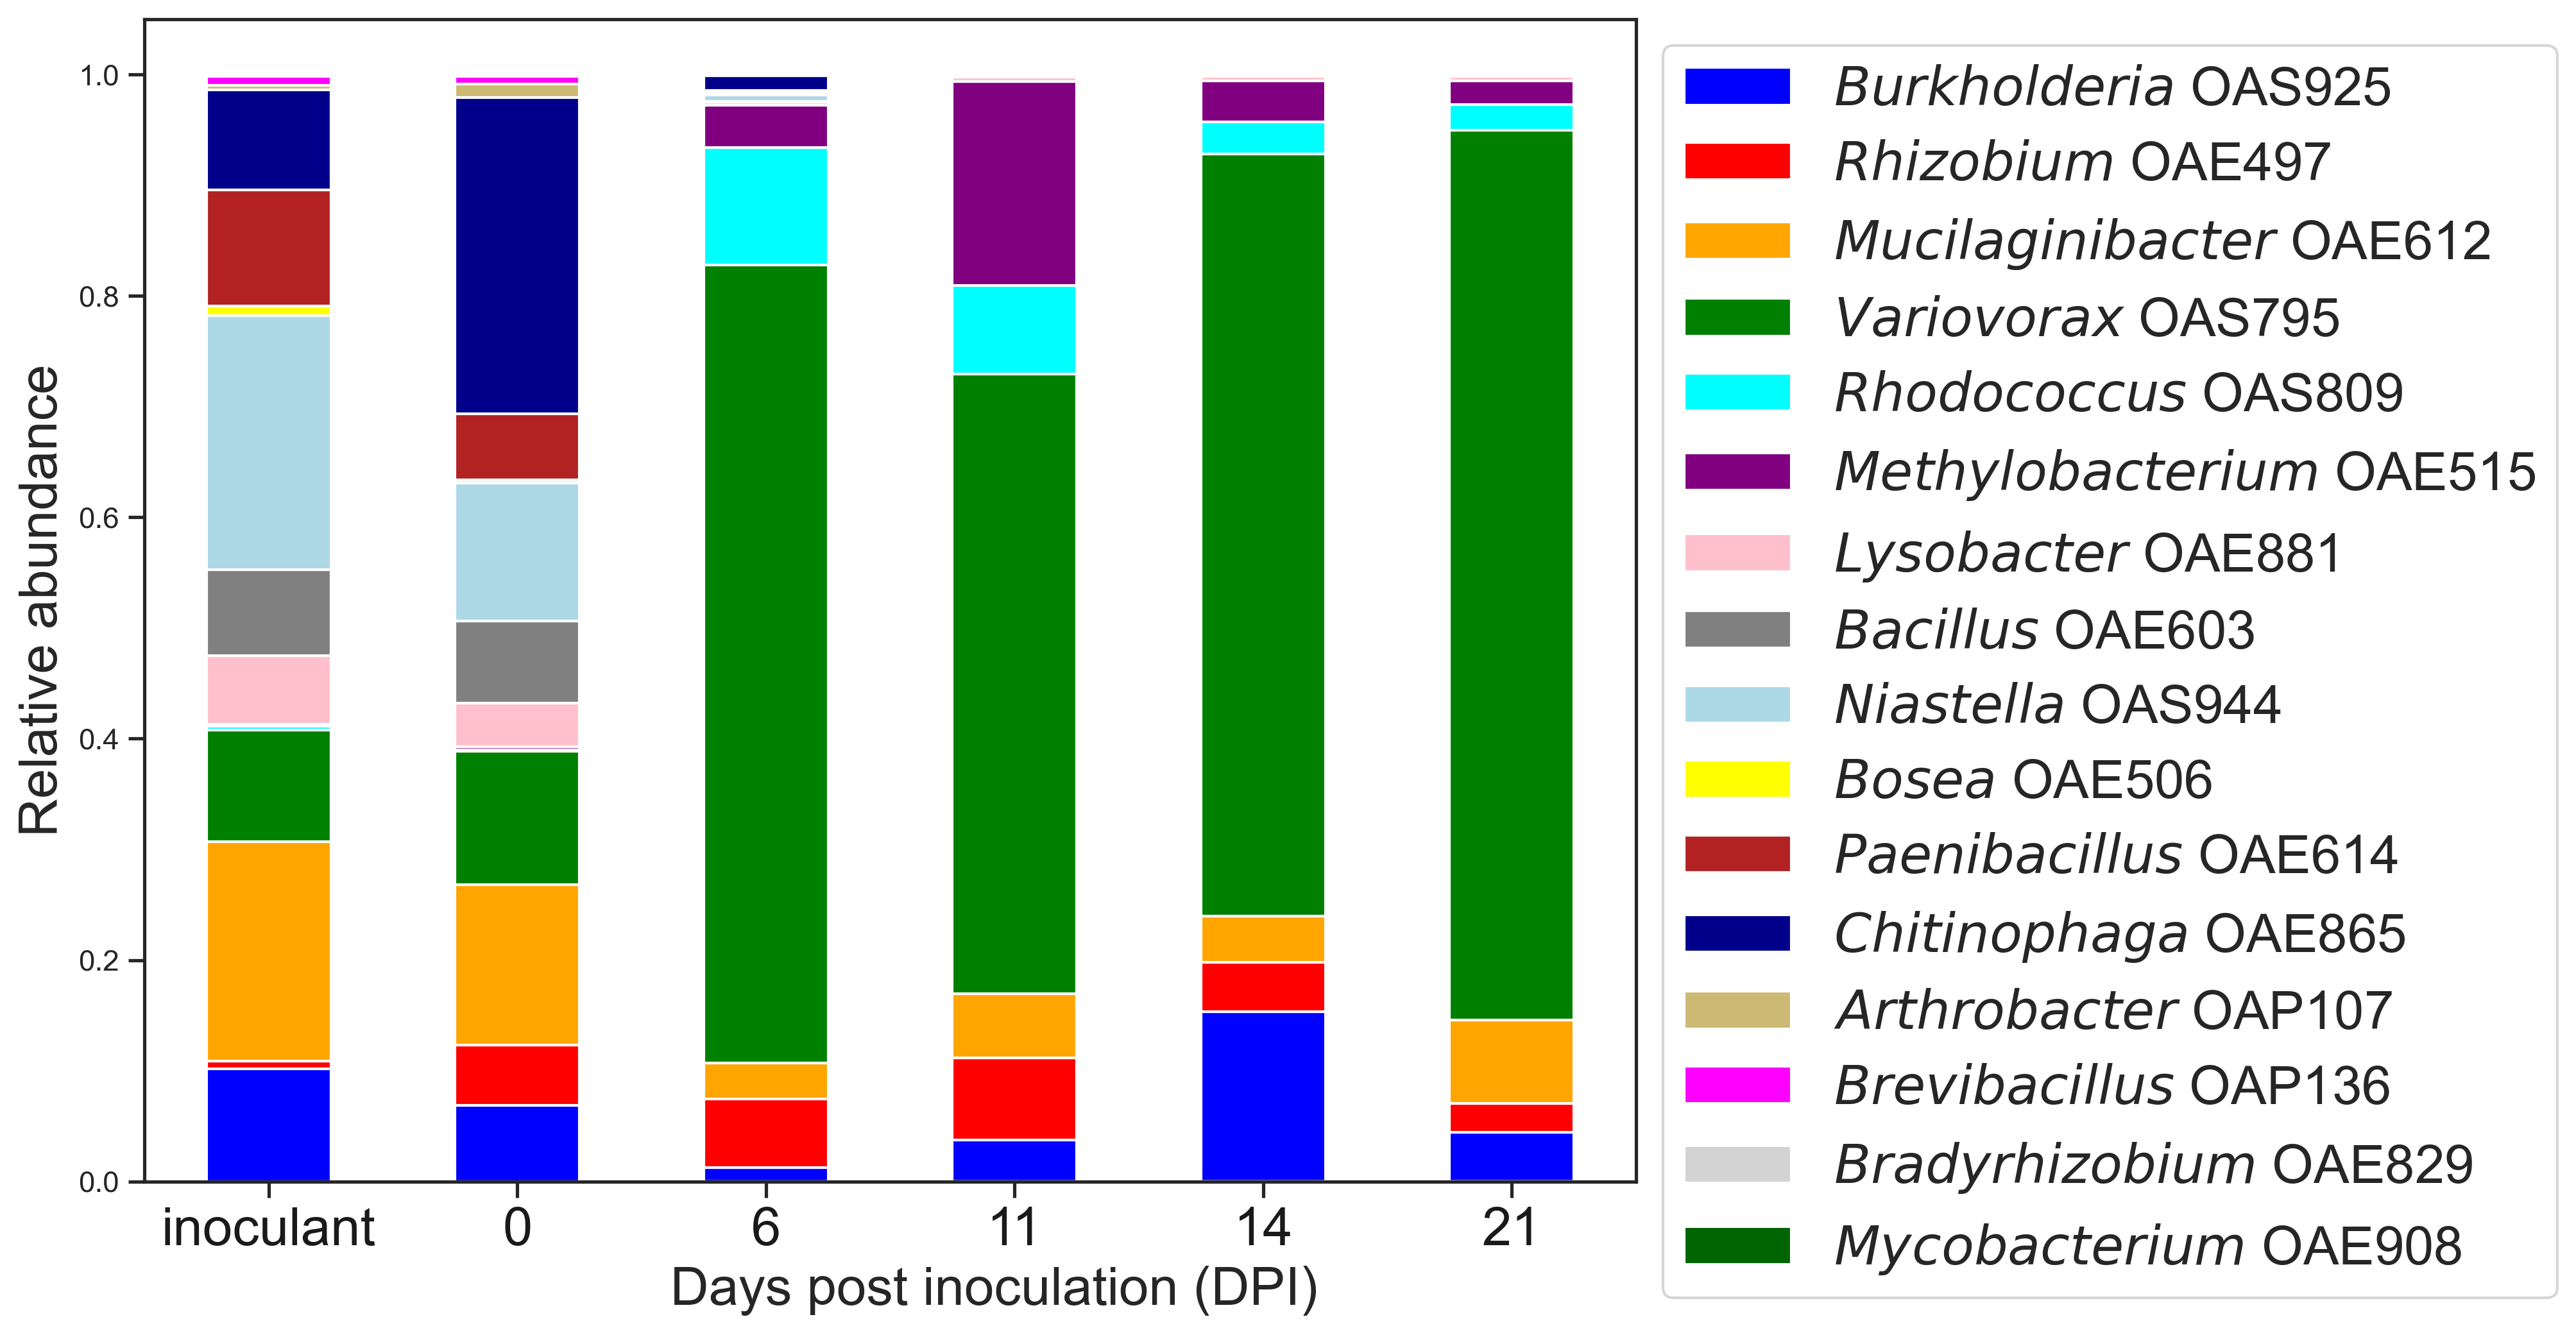

In [7]:
### This generates the relative abundance plot based on group
fig_labels = ['$\it{Burkholderia}$ OAS925', '$\it{Rhizobium}$ OAE497', '$\it{Mucilaginibacter}$ OAE612',
       '$\it{Variovorax}$ OAS795', '$\it{Rhodococcus}$ OAS809', '$\it{Methylobacterium}$ OAE515',
       '$\it{Lysobacter}$ OAE881', '$\it{Bacillus}$ OAE603', '$\it{Niastella}$ OAS944',
       '$\it{Bosea}$ OAE506', '$\it{Paenibacillus}$ OAE614', '$\it{Chitinophaga}$ OAE865',
       '$\it{Arthrobacter}$ OAP107', '$\it{Brevibacillus}$ OAP136', '$\it{Bradyrhizobium}$ OAE829',
       '$\it{Mycobacterium}$ OAE908']
syncolors=['blue','red','orange','green','cyan','purple','pink','grey','lightblue','yellow','firebrick','darkblue','y','magenta','lightgray','darkgreen']


sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")
synplot3=selsynavgs[synlist].T/selsynavgs[synlist].T.sum(axis=0)
synplot3=synplot3.T
ax=synplot3.plot.bar(stacked=True, figsize=(10, 8),color=syncolors)
x_name = ["inoculant", "0", "6", "11", "14", "21"]
ax.legend(labels = fig_labels,
          bbox_to_anchor=(1.0, 1.0), fontsize = 20)
ax.set_xticklabels(labels = x_name, fontsize = 20, rotation = 0)
ax.set_xlabel("              Days post inoculation (DPI)", fontsize = 20)
ax.set_ylabel('Relative abundance', fontsize = 20)

for ticklabel, tickcolor in zip(ax.get_xticklabels(), namecols):
    ticklabel.set_color(tickcolor)